In [1]:
import numpy as np
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Notebook to produce the relationship of a projectile fired from ground level.
- Velocity
- Angle
- Time

In [2]:
# helper function to determine given distance and height at angle and time
def projectile(angle, time, velocity = 30):
    """
    return the height and distance of an object projected at a given 
    angle in radians at a given time at a given velocity; 
    30 meters/second assumed value for velocity
    """

    # gravity constant (assumed); meters per second squared
    g = 9.81

    x = velocity * time * np.cos(angle) 

    y = (velocity * time * np.sin(angle)) - ((g * (time**2)) * 0.5)

    return x, y, velocity

In [3]:
# create data based on projectile formula
# possible problem with the unit 5 demarcations

# 300 time slices between 0 and 5 seconds
time = np.linspace(0, 5, 300)

# a range of angles from 20 to 60 degrees by 5 degree increments
ang = np.arange(20, 60, 5)

# range of velocities from 5 to 50 m/s
velocities = np.arange(5, 55, 5)

In [4]:
# an object will hold angle keys with values of an object of x and y values demarcated by time
example_projectiles = {}

In [5]:
%%time
for a in ang:
    # reset the collection for each angle over time
    x_values = []
    y_values = []
    time_stamp = []
    velocity_values = []
    
    # convert the angle to radians
    ang_rad = (np.pi * a)/180

    for v in velocities:
        for t in time:
            x, y, vel = projectile(ang_rad, t, v)        
            x_values.append(x)
            y_values.append(y)
            time_stamp.append(t)
            velocity_values.append(vel)
                   
    example_projectiles[a] = {
        "dist": x_values,
        "height": y_values,
        "times": time_stamp, 
        "velocity": velocity_values
    }

CPU times: user 54.4 ms, sys: 4.08 ms, total: 58.5 ms
Wall time: 58.6 ms


# Prepare Data

In [6]:
g = torch.Generator().manual_seed(1337)

In [7]:
def prepare_X_Y(examples = example_projectiles, angles = ang):
    """
    Arguments:
    - object with key of angle and values an object of lists of:
        - distance
        - height
        - times of flight 
        - velocity
    - a list of angles 

    Return:
    - Two matrices:
        - X: [number of samples, [velocity, time in flight, angle]]
        - Y: [number of samples, [distance at point of flight, 
                 height of projectile at point of flight, angle]]

    Negative height values are included to train the nn and need to 
        be filtered for use
    """

    # individual features
    angles_list = []
    distance = []
    height = []
    times = []
    velocity = []

    for ang in angles:
        ang_height = example_projectiles[ang]['height']
        ang_dist = example_projectiles[ang]['dist']
        ang_velocity = example_projectiles[ang]['velocity']
        ang_times = example_projectiles[ang]['times']
        ang_list = [ang] * len(ang_times) 

        angles_list.extend(ang_list)
        distance.extend(ang_dist)
        height.extend(ang_height)
        times.extend(ang_times)
        velocity.extend(ang_velocity)

    # final returns
    X = np.vstack([velocity, times, angles_list])
    X = X.T

    Y = np.vstack([distance, height, angles_list])
    Y = Y.T

    return X, Y

In [8]:
X, Y = prepare_X_Y()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1, random_state = 42)

In [10]:
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)

X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)

In [11]:
print(X_train.shape, y_train.shape)

torch.Size([21600, 3]) torch.Size([21600, 3])


# Train model

In [12]:
batch_size = 300

In [13]:
# hard coded batch size

class NNModelEX1(nn.Module):
    """
    Inputs of velocity and angle must be lists of a single value for the changing interval of time
    
    From inputs:
    - velocity of projectile
    - time in path (input as a list/tensor)
    - angle of launch
    
    Model outputs:
    - distance traveled
    - height of projectile
    - angle launched
    """
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3, 300),
            nn.ReLU(),
            nn.Linear(300, 300, 500),
            nn.ReLU(),
            nn.Linear(300, 300),
            nn.ReLU(),
            nn.Linear(300, 3),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [14]:
def create_model(model = NNModelEX1()):
    optimizer = optim.Adam(model.parameters(), lr = 0.01) 
    return model, optimizer

In [15]:
def loss_fx(pred, y):
    return ((pred - y)**2).mean()

# loss_func = loss_fx
# loss_func = F.cross_entropy
loss_func = nn.MSELoss()

In [16]:
def train_model(model, optimizer, loss_func, epochs):
    """ 
    Arguments:
    - Model instance
    - Loss function to use in training
    - Number of epochs to use in training

    Returns:
    - Model trained to provided number of epochs
    """

    for epoch in range(epochs):
        ix = torch.randint(0, X_train.shape[0], (batch_size,), generator = g)
        x = X_train[ix]
        y = y_train[ix]
        pred = model(x)
        loss = loss_func(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if (epoch % 1000 == 0):
            print(f"Current epoch {epoch} with loss {loss}")

    return model

In [17]:
model, optimizer = create_model()
epochs = 5000

In [18]:
model = train_model(model, optimizer, loss_func, epochs)

Current epoch 0 with loss 2747.292236328125
Current epoch 1000 with loss 3.0400900840759277
Current epoch 2000 with loss 2.3956491947174072
Current epoch 3000 with loss 1.2125394344329834
Current epoch 4000 with loss 0.2561474144458771


In [19]:
ix_eval = torch.randint(0, X_test.shape[0], (batch_size,), generator = g)
x_eval = X_test[ix_eval]
y_eval = y_test[ix_eval]
# print(x_eval)
# print(y_eval)

In [20]:
# x_eval

In [21]:
x_pred = model(x_eval)
print(loss_func(x_pred, y_eval))

tensor(0.3650, grad_fn=<MseLossBackward0>)


In [22]:
# x_pred.tolist()[:5]

In [23]:
# y_eval.tolist()[:5]

-------------------------------------------------------

### To load the best performing model:

In [24]:
# https://pytorch.org/tutorials/beginner/basics/saveloadrun_tutorial.html
# torch.save(model, 'model.pth')  ;   tensor(0.0563, grad_fn=<MseLossBackward0>)
# model = torch.load('model.pth')

--------------------------------------------------------------

In [25]:
def calculate_trajectory(angle, velocity, projectile = projectile):
    """
    Trajectory calculated over a 5 second time period divided into 300 intervals
    Arguments:
    - Angle of the projectile
    - velocity of the projectile
    - projectile formula to use

    Returns:
    - X: distances in a list
    - Y: heights in a list
    """
    X, Y = [], []
    ang_rad = (np.pi * angle)/180

    for t in np.linspace(0, 5, 300):
        x, y, _ = projectile(ang_rad, t, velocity)
        if y >=0:
            X.append(x)
            Y.append(y)

    return X, Y

In [26]:
def predict_trajectory(angle, velocity, model = model):
    """
    Trajectory if predicted for a 5 second period divided into 300 intervals

    Arguments:
    - angle of projectile
    - velocity of projectile

    Returns: 
    - X: prediction of distance values
    - Y: prediction of height values at given distances
    """

    time = np.linspace(0, 5, 300)
    

    vel = [velocity] * 300
    angle = [angle] * 300

    inputs = np.vstack([vel, time, angle])
    inputs = torch.Tensor(inputs.T)

    predictions = model(inputs)
    predictions = predictions.tolist()
    predictions = [pred for pred in predictions if pred[1] > 0]

    X = [p[0] for p in predictions]
    Y = [p[1] for p in predictions]

    return X, Y

In [27]:
def plot_comparison(X_calc, Y_calc, X_pred, Y_pred):
    fig = plt.figure(figsize=(9,9))
    gs = fig.add_gridspec(2,2, height_ratios=[1,3])    
        
    ax = fig.add_subplot(gs[1, :]) # main plot
    ax.plot(X_pred, Y_pred, c='darkblue', label="Predicted")
    ax.plot(X_calc, Y_calc, c='red', label="Calculated")
    ax.set_title("Comparison of predicted and calculated trajectories")
    ax.legend()

    ax_pred = fig.add_subplot(gs[0, 0])
    ax_pred.plot(X_pred, Y_pred, c='darkblue')
    ax_pred.set_title("Predicted trajectory")

    ax_actual = fig.add_subplot(gs[0, 1])
    ax_actual.plot(X_calc, Y_calc, c='red')
    ax_actual.set_title("Calculated trajectory")

    plt.show()


# Choose trajectory parameters

In [28]:
target_angle = 33
target_velocity = 37

--------------------------------------------------------------------

In [29]:
X_pred, Y_pred = predict_trajectory(target_angle, target_velocity)

In [30]:
X_calc, Y_calc = calculate_trajectory(target_angle, target_velocity)

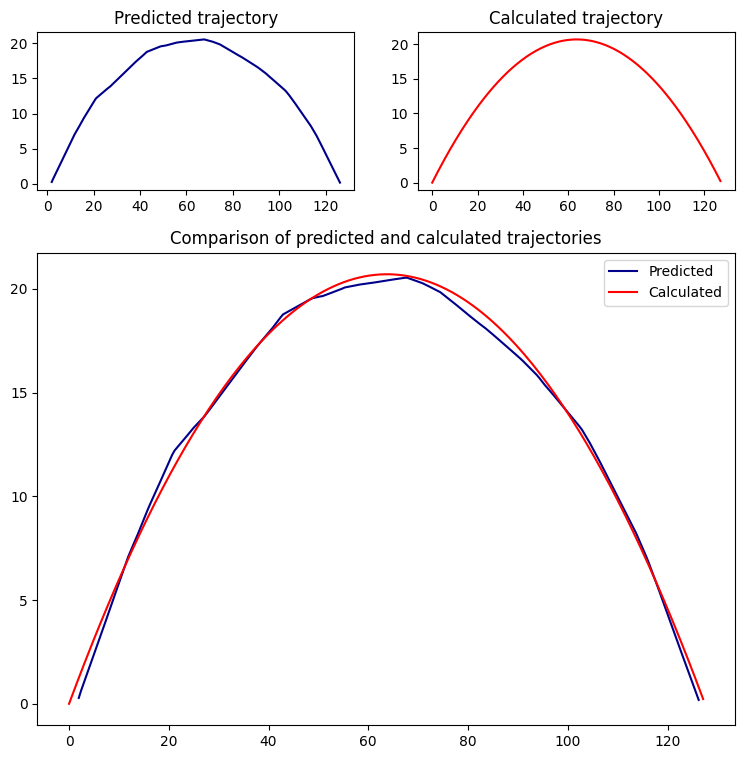

In [31]:
plot_comparison(X_calc, Y_calc, X_pred, Y_pred)